In [211]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import statistics
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0

First we will save the file-paths which we will be using in this notebook

In [292]:
main_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus"

Now we will visualize a image at random with its label name to identify how our image looks.
The train_images folder itself contains only the images, but the labels are in the train_images.csv file. In order to have a real training set, the images and labels must be linked together.


In [335]:
train_labels = pd.read_csv(os.path.join(main_path, "train_images.csv"))
train_labels.head()

,image_path,label
0,/train_images/1.jpg,1
1,/train_images/2.jpg,1
2,/train_images/3.jpg,1
3,/train_images/4.jpg,1
4,/train_images/5.jpg,1


In [337]:
images_dir = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images"
required_size = (224, 224)
#check every image
non_standard_images = []
for image_file in os.listdir(images_dir):
    if image_file.endswith((".jpg", ".jpeg", ".png")):  # Ensure it checks image files only
        image_path = os.path.join(images_dir, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if (width, height) != required_size:
                    non_standard_images.append((image_file, width, height))
        except Exception as e:
            print(f"Error opening image {image_file}: {e}")
#print out non-standard images
if non_standard_images:
    print(f"Images that do not match the size {required_size}:")
    for img in non_standard_images:
        print(f"File: {img[0]}, Size: {img[1]}x{img[2]}")
else:
    print(f"All images are of size {required_size}.")

Images that do not match the size (224, 224):
File: 63.jpg, Size: 271x404
File: 823.jpg, Size: 500x421
File: 3578.jpg, Size: 500x336
File: 2666.jpg, Size: 500x364
File: 2100.jpg, Size: 500x333
File: 1409.jpg, Size: 500x333
File: 189.jpg, Size: 375x500
File: 2114.jpg, Size: 500x333
File: 2672.jpg, Size: 500x375
File: 77.jpg, Size: 357x500
File: 837.jpg, Size: 500x301
File: 2882.jpg, Size: 500x389
File: 3544.jpg, Size: 500x318
File: 1353.jpg, Size: 500x375
File: 1435.jpg, Size: 500x333
File: 3222.jpg, Size: 500x359
File: 2128.jpg, Size: 500x357
File: 3236.jpg, Size: 500x333
File: 1421.jpg, Size: 500x333
File: 1347.jpg, Size: 500x334
File: 2896.jpg, Size: 333x500
File: 3550.jpg, Size: 500x350
File: 638.jpg, Size: 500x415
File: 2869.jpg, Size: 500x319
File: 1390.jpg, Size: 500x334
File: 604.jpg, Size: 500x375
File: 2699.jpg, Size: 433x500
File: 2841.jpg, Size: 500x393
File: 3587.jpg, Size: 500x376
File: 162.jpg, Size: 500x332
File: 176.jpg, Size: 500x362
File: 2855.jpg, Size: 398x500
File:

All images are size 224x224

Preparing the Data

Collecting the labels and mapping the labels to the birds name

In [338]:
class_names = np.load("class_names.npy", allow_pickle=True).item()
print(class_names) 
#reverse the dictionary to map labels to class names
label_to_class_name = {v: k for k, v in class_names.items()}
#map the label column in train_labels to class names
train_labels['class_name'] = train_labels['label'].map(label_to_class_name)
#clean up the class names by extracting the meaningful part (e.g., after the first '.')
train_labels['class_name'] = train_labels['class_name'].apply(lambda name: name.split('.')[1] if isinstance(name, str) else name)
print(train_labels.head())

{'001.Black_footed_Albatross': 1, '002.Laysan_Albatross': 2, '003.Sooty_Albatross': 3, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 5, '006.Least_Auklet': 6, '007.Parakeet_Auklet': 7, '008.Rhinoceros_Auklet': 8, '009.Brewer_Blackbird': 9, '010.Red_winged_Blackbird': 10, '011.Rusty_Blackbird': 11, '012.Yellow_headed_Blackbird': 12, '013.Bobolink': 13, '014.Indigo_Bunting': 14, '015.Lazuli_Bunting': 15, '016.Painted_Bunting': 16, '017.Cardinal': 17, '018.Spotted_Catbird': 18, '019.Gray_Catbird': 19, '020.Yellow_breasted_Chat': 20, '021.Eastern_Towhee': 21, '022.Chuck_will_Widow': 22, '023.Brandt_Cormorant': 23, '024.Red_faced_Cormorant': 24, '025.Pelagic_Cormorant': 25, '026.Bronzed_Cowbird': 26, '027.Shiny_Cowbird': 27, '028.Brown_Creeper': 28, '029.American_Crow': 29, '030.Fish_Crow': 30, '031.Black_billed_Cuckoo': 31, '032.Mangrove_Cuckoo': 32, '033.Yellow_billed_Cuckoo': 33, '034.Gray_crowned_Rosy_Finch': 34, '035.Purple_Finch': 35, '036.Northern_Flicker': 36, '037.Acadian_Flyca

In [339]:
labels = train_labels["label"].unique()
bird_name_map = {int(i): train_labels[train_labels["label"] == i]["class_name"].values[0] for i in labels}
print(labels)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


In [340]:
print(bird_name_map)

{1: 'Black_footed_Albatross', 2: 'Laysan_Albatross', 3: 'Sooty_Albatross', 4: 'Groove_billed_Ani', 5: 'Crested_Auklet', 6: 'Least_Auklet', 7: 'Parakeet_Auklet', 8: 'Rhinoceros_Auklet', 9: 'Brewer_Blackbird', 10: 'Red_winged_Blackbird', 11: 'Rusty_Blackbird', 12: 'Yellow_headed_Blackbird', 13: 'Bobolink', 14: 'Indigo_Bunting', 15: 'Lazuli_Bunting', 16: 'Painted_Bunting', 17: 'Cardinal', 18: 'Spotted_Catbird', 19: 'Gray_Catbird', 20: 'Yellow_breasted_Chat', 21: 'Eastern_Towhee', 22: 'Chuck_will_Widow', 23: 'Brandt_Cormorant', 24: 'Red_faced_Cormorant', 25: 'Pelagic_Cormorant', 26: 'Bronzed_Cowbird', 27: 'Shiny_Cowbird', 28: 'Brown_Creeper', 29: 'American_Crow', 30: 'Fish_Crow', 31: 'Black_billed_Cuckoo', 32: 'Mangrove_Cuckoo', 33: 'Yellow_billed_Cuckoo', 34: 'Gray_crowned_Rosy_Finch', 35: 'Purple_Finch', 36: 'Northern_Flicker', 37: 'Acadian_Flycatcher', 38: 'Great_Crested_Flycatcher', 39: 'Least_Flycatcher', 40: 'Olive_sided_Flycatcher', 41: 'Scissor_tailed_Flycatcher', 42: 'Vermilion_Fl

## Split into training, validation and test set
An accepted approach is to devide the data into 70 percent for training, 20 percent for testing and 10 ercent for validation. The model is trained with the training data meaning the parameters of the model are updated using these examples 

In [341]:
train_val_data, test_data = train_test_split(
    train_labels, 
    test_size=0.2,  # 20% for test
    stratify=train_labels['label'],
    random_state=42 
)
#split training+validation into training (70%) and validation (10%)
train_data, val_data = train_test_split(
    train_val_data, 
    test_size=0.125,  # 10% of the total (0.1 / 0.8 = 0.125 of train_val_data)
    stratify=train_val_data['label'], 
    random_state=42  
)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2747
Validation size: 393
Test size: 786


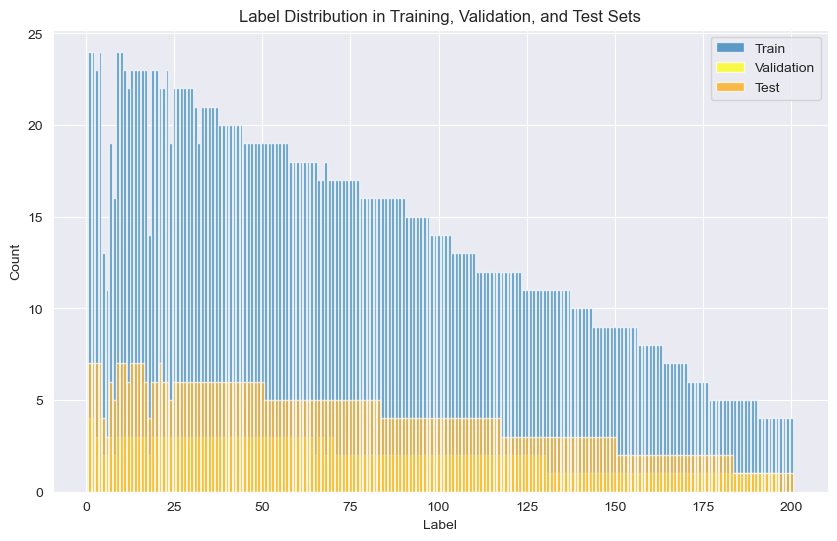

In [299]:
import matplotlib.pyplot as plt

# Get label counts for training, validation, and test sets
train_label_counts = train_data['label'].value_counts()
val_label_counts = val_data['label'].value_counts()
test_label_counts = test_data['label'].value_counts()

# Create a bar chart for training and validation sets
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training data
ax.bar(train_label_counts.index, train_label_counts.values, label='Train', alpha=0.7)

# Plot validation data
ax.bar(val_label_counts.index, val_label_counts.values, label='Validation', alpha=0.7, color='yellow')

# Plot test data
ax.bar(test_label_counts.index, test_label_counts.values, label='Test', alpha=0.7, color='orange')

# Set labels and title
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Label Distribution in Training, Validation, and Test Sets")
ax.legend()

# Show plot
plt.show()


In [346]:
# Define output paths for all datasets

training_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/training_data.csv"
validation_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv"
test_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test_data.csv"

# Save the datasets to their respective CSV files
train_data.to_csv(training_output_path, index=False)
val_data.to_csv(validation_output_path, index=False)
test_data.to_csv(test_output_path, index=False)

# Print confirmation for each saved file
print(f"Training data saved to {training_output_path}")
print(f"Validation data saved to {validation_output_path}")
print(f"Test data saved to {test_output_path}")


Training data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/training_data.csv
Validation data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv
Test data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test_data.csv


In [347]:
main_train_path= "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train"

In [348]:

train = os.path.join(main_path,'real_training_data')
test = os.path.join(main_path,'real_test_data')
valid = os.path.join(main_path,'real_valid_datan')


## Visulalize the images
Now we will visualize a image at random with its label name to identify how our image looks

In [352]:
# Path to your CSV file
csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/train/real_training_data/training_data.csv"
# Path to your train images folder
import os

image_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_training_data"


for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.endswith((".jpg", ".png")):  # Csak képfájlok
            image_path = os.path.join(root, file)
            print(f"Found image: {image_path}")

            base_dir = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data"
subfolder = "class_1"  # Példa osztály neve
filename = "image1.jpg"

image_path = os.path.join(base_dir, subfolder, filename)



# Read the CSV
train_data = pd.read_csv(csv_path)

# Randomly select a row from the dataframe
random_entry = train_data.sample(n=1).iloc[0]

# Extract the image path and label
image_name = random_entry['image_path']  # Full image path
label = random_entry['class_name']  # Class name

# Combine the folder path with the image path
image_path = os.path.join(image_folder, os.path.basename(image_name))

# Verify if the image exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at path: {image_path}")


img = mimg.imread(image_path)
plt.figure(figsize=(5, 5))
plt.title(label)  
plt.axis('off')
plt.imshow(img)
plt.show()


Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/63.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/823.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/3578.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/2666.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/2100.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/1409.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/189.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/test_images/test_images/2114.jpg
Found image: /Users/bognarlili/Downloads/aml-2024-fe

FileNotFoundError: Image not found at path: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/2301.jpg

## Creating subdirectories for tensorflow

In [371]:
import shutil

# Move class folders into real_training_data
source_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/"
target_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data/"

for folder in os.listdir(source_path):
    full_path = os.path.join(source_path, folder)
    if os.path.isdir(full_path) and folder not in ["real_training_data", "real_test_data", "real_valid_data"]:
        shutil.move(full_path, target_path)


In [330]:
import os

# Print the contents of the training data directory
for root, dirs, files in os.walk("/Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data"):
    print(f"Root: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    break  # Print only the top-level structure


Root: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/real_training_data
Subdirectories: ['test_images', 'organized_data', 'train']
Files: ['.DS_Store', 'test_data.csv']


## Checking distribution of images in each class
Now we will check the distributuon of images across different classes, it is necessary because if images are not distributed evenly across the classes, there might be chances that our model can underfit or overfit on the data.

In [370]:
import pandas as pd
import os
import statistics

# Define paths
csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train_data.csv"  # Path to train_data.csv

# Read the CSV file
train_data = pd.read_csv(csv_path)

# Initialize a dictionary to store species and their image counts
store_species_count = {}

# Count the number of images per species
for species in train_data['class_name'].unique():
    count_imgs = train_data[train_data['class_name'] == species].shape[0]
    store_species_count[species] = count_imgs

# Find the species with the minimum number of images
min_key, min_value = min(store_species_count.items(), key=lambda x: x[1])

# Find the species with the maximum number of images
max_key, max_value = max(store_species_count.items(), key=lambda x: x[1])

# Get a list of the image counts
values_list = list(store_species_count.values())

# Compute the median value of image counts
median_value = statistics.median(values_list)

# Print the results
print("Minimum count of images in a class:", min_value, "corresponding Species:", min_key)
print("Maximum count of images in a class:", max_value, "corresponding Species:", max_key)
print("Median value:", median_value, "images")


Minimum count of images in a class: 4 corresponding Species: Winter_Wren
Maximum count of images in a class: 28 corresponding Species: Black_footed_Albatross
Median value: 16.0 images


In [369]:
train_csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_training_data/training_data.csv"

base_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/"
train_data = pd.read_csv(train_csv_path)
train_data['image_path'] = train_data['image_path'].apply(
    lambda x: os.path.join(base_path, os.path.basename(x))
)

missing_files = [path for path in train_data['image_path'] if not os.path.exists(path)]
print(f"missing images: {len(missing_files)}")
train_data.to_csv(train_csv_path, index=False)

Hiányzó képek száma: 0


In [372]:
# Validation data
valid_csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_valid_data/validation_data.csv"
valid_data = pd.read_csv(valid_csv_path)
valid_data['image_path'] = valid_data['image_path'].apply(
    lambda x: os.path.join(base_path, os.path.basename(x))
)
valid_data.to_csv(valid_csv_path, index=False)

# Test data
test_csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_test_data/test_data.csv"
test_data = pd.read_csv(test_csv_path)
test_data['image_path'] = test_data['image_path'].apply(
    lambda x: os.path.join(base_path, os.path.basename(x))
)
test_data.to_csv(test_csv_path, index=False)


In [374]:
train_classes = set(train_data['class_name'].unique())
validation_classes = set(classes_in_validation)  # Már a mappanevekből származik

print(f"Train oclass nr: {len(train_classes)}")
print(f"Validation class nr: {len(validation_classes)}")
print(f"missing from validation: {train_classes - validation_classes}")

missing_classes = train_classes - validation_classes
for class_name in missing_classes:
    class_dir = os.path.join(validation_path, class_name)
    os.makedirs(class_dir, exist_ok=True)
print("missing replaced.")

for class_name in missing_classes:
    train_class_dir = os.path.join(train_output_path, class_name)
    val_class_dir = os.path.join(validation_path, class_name)
    
   
    train_images = os.listdir(train_class_dir)
    val_images = train_images[:len(train_images)//5]  # Példa: 20%-át validációba teszed
    
    for image in val_images:
        shutil.move(os.path.join(train_class_dir, image), val_class_dir)
print("missed classes replaced.")

classes_in_validation = os.listdir(validation_path)
print(f"Validation classes: {len(classes_in_validation)}")
print(f"missing classes: {train_classes - set(classes_in_validation)}")



Train osztályok száma: 200
Validation osztályok száma: 0
Hiányzó osztályok a validációból: {'Palm_Warbler', 'Scott_Oriole', 'Pomarine_Jaeger', 'Summer_Tanager', 'Western_Meadowlark', 'Pied_Kingfisher', 'Blue_Jay', 'Frigatebird', 'Brandt_Cormorant', 'Chipping_Sparrow', 'Least_Tern', 'Green_Kingfisher', 'Grasshopper_Sparrow', 'Indigo_Bunting', 'Rusty_Blackbird', 'Northern_Waterthrush', 'Henslow_Sparrow', 'Worm_eating_Warbler', 'Hooded_Merganser', 'Mangrove_Cuckoo', 'Northern_Flicker', 'Song_Sparrow', 'Cactus_Wren', 'Baird_Sparrow', 'Rhinoceros_Auklet', 'Great_Grey_Shrike', 'Ivory_Gull', 'Loggerhead_Shrike', 'Mallard', 'Fox_Sparrow', 'Prairie_Warbler', 'Elegant_Tern', 'Magnolia_Warbler', 'White_eyed_Vireo', 'Cedar_Waxwing', 'Least_Auklet', 'Common_Tern', 'Field_Sparrow', 'Yellow_billed_Cuckoo', 'Nighthawk', 'Shiny_Cowbird', 'Crested_Auklet', 'Scissor_tailed_Flycatcher', 'Mourning_Warbler', 'American_Crow', 'Tree_Sparrow', 'Horned_Grebe', 'Hooded_Warbler', 'American_Pipit', 'Gray_Catbird',

Error: Destination path '/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/validation/Palm_Warbler/3746.jpg' already exists

In [375]:
import os
import shutil
import pandas as pd

# Útvonalak beállítása
csv_paths = {
    "train": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_training_data/training_data.csv",
    "validation": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_valid_data/validation_data.csv",
    "test": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/real_test_data/test_data.csv"
}

image_base_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images"

output_paths = {
    "train": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/train",
    "validation": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/validation",
    "test": "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/test"
}


def organize_images(csv_path, images_path, output_path):
    # CSV beolvasása
    data = pd.read_csv(csv_path)
    

    for class_name in data['class_name'].unique():
        class_dir = os.path.join(output_path, class_name)
        os.makedirs(class_dir, exist_ok=True)
    
    
    for _, row in data.iterrows():
        src_path = os.path.join(images_path, os.path.basename(row['image_path']))
        dest_path = os.path.join(output_path, row['class_name'], os.path.basename(row['image_path']))
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)  # Másolás vagy áthelyezés (copy/move)
        else:
            print(f"Image not found: {src_path}")


for dataset, csv_path in csv_paths.items():
    print(f"Organizing {dataset} dataset...")
    organize_images(csv_path, image_base_path, output_paths[dataset])
    print(f"{dataset.capitalize()} dataset organized successfully!")


Organizing train dataset...
Train dataset organized successfully!
Organizing validation dataset...
Validation dataset organized successfully!
Organizing test dataset...
Test dataset organized successfully!


## Categorizing the images
Here we are using Tensorflows ImageDataGenerator function this function takes image directory path. preprocess the image and stratify the count of images in each class such that each class has same number of images for model training.

In [376]:
train_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/train"
print(os.path.exists(train_output_path))  # Ellenőrizd, hogy valóban létezik-e
print(f"Útvonal hossza: {len(train_output_path)}")  # Ellenőrizd az útvonal hosszát
valid_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/validation"
test_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/test"

os.makedirs(validation_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

print(f"Validation létezik: {os.path.exists(validation_path)}")
print(f"Test létezik: {os.path.exists(test_path)}")

True
Útvonal hossza: 74
Validation létezik: True
Test létezik: True


In [408]:
train_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_set = train_gen.flow_from_directory(
    "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/train",
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

# Getting data for testing
test_gen = ImageDataGenerator()
valid_set = train_gen.flow_from_directory(
    "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/validation",
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)
# getting data for validation
valid_gen = ImageDataGenerator()
test_set = train_gen.flow_from_directory(
    "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/organized_data/test",
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

print("Datasets are ready for training!")


Found 3140 images belonging to 200 classes.
Found 412 images belonging to 200 classes.
Found 786 images belonging to 200 classes.
Datasets are ready for training!


In [323]:
# geting the labels from training data, it will be later used to predict the class when an image is passed

labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
len(labels)

200

Below we see that we are not preprocessing test and validation data, its because we will be using this images to see how well our model predicts.

## Creating our model
Now we are ready with our data lets start building our image classifier model, for that first we need to get EfficientNetB0 model from Tensorfow Keras API, more about EfficientNetB0 can be found here https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

Below we can also see that we are setting the layers of our EfficientNetB0 to False, its because this model has already been trained on larger set of image data and we are using it classify our birds species, also if we want we can set layers to true, but it will consume more time in training our model.

In [413]:
# Downloading the pre-trained model from API
eff_net_model = EfficientNetB0(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='max',
                    classes=len(labels)
                )

# setting all the layers of this model to false
for layer in eff_net_model.layers:
    layer.trainable = False


After we download EfficientNetB0, We are adding custom dense layers to the model so that our model can classify images based on 200 diffent labels.

In [386]:
model = Sequential()
model.add(eff_net_model)
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1280,activation='relu'))
model.add(Dense(len(labels),activation='softmax'))


model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1280)           │     1,312,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │       256,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,933,611 (26.45 MB)

 Trainable params: 2,881,992 (10.99 MB)

 Non-trainable params: 4,051,619 (15.46 MB)


Now we will its time to select our optimizer for our model, Adam Optimizer is the best optimizer for our use case as it has better optimization and faster compuation time, we can also set learnign rate for our optimizer, I have used 0.00001 as my learning_rate value, this is the best learning rate value for our use-case.

In [394]:

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) ,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [395]:


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early = tf.keras.callbacks.EarlyStopping(patience = 5)

modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/bognarlili/Downloads/final_model.keras',
    save_best_only=True,  
    monitor='val_loss',   
    mode='min'           
)


## Training the Model
Now we have built our model and specified required optimizer and callbacks, its time to train our model and visualize the training results

In [396]:
model_hist = model.fit(train_set,validation_data = valid_set,epochs = 20,callbacks = [modelcheck_lr,early])

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 620ms/step - accuracy: 0.1227 - loss: 4.5084 - val_accuracy: 0.3544 - val_loss: 3.0776
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 60s 605ms/step - accuracy: 0.3704 - loss: 3.0826 - val_accuracy: 0.4612 - val_loss: 2.3736
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 678ms/step - accuracy: 0.4586 - loss: 2.4427 - val_accuracy: 0.5558 - val_loss: 1.9346
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 79s 799ms/step - accuracy: 0.5336 - loss: 2.0494 - val_accuracy: 0.6432 - val_loss: 1.5677
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 81s 821ms/step - accuracy: 0.6105 - loss: 1.7294 - val_accuracy: 0.7136 - val_loss: 1.3733
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6315 - loss: 1.5695 - val_accuracy: 0.7063 - val_loss: 1.2904
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 89s 898ms/step - accuracy: 0.6673 - loss: 1.4260 - val_accuracy: 0.7403 - val_loss: 1.1234
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 877ms/step - accuracy: 0.7091 - loss: 1.3038 - val_accura

In [409]:
 #Visualizing the result 
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

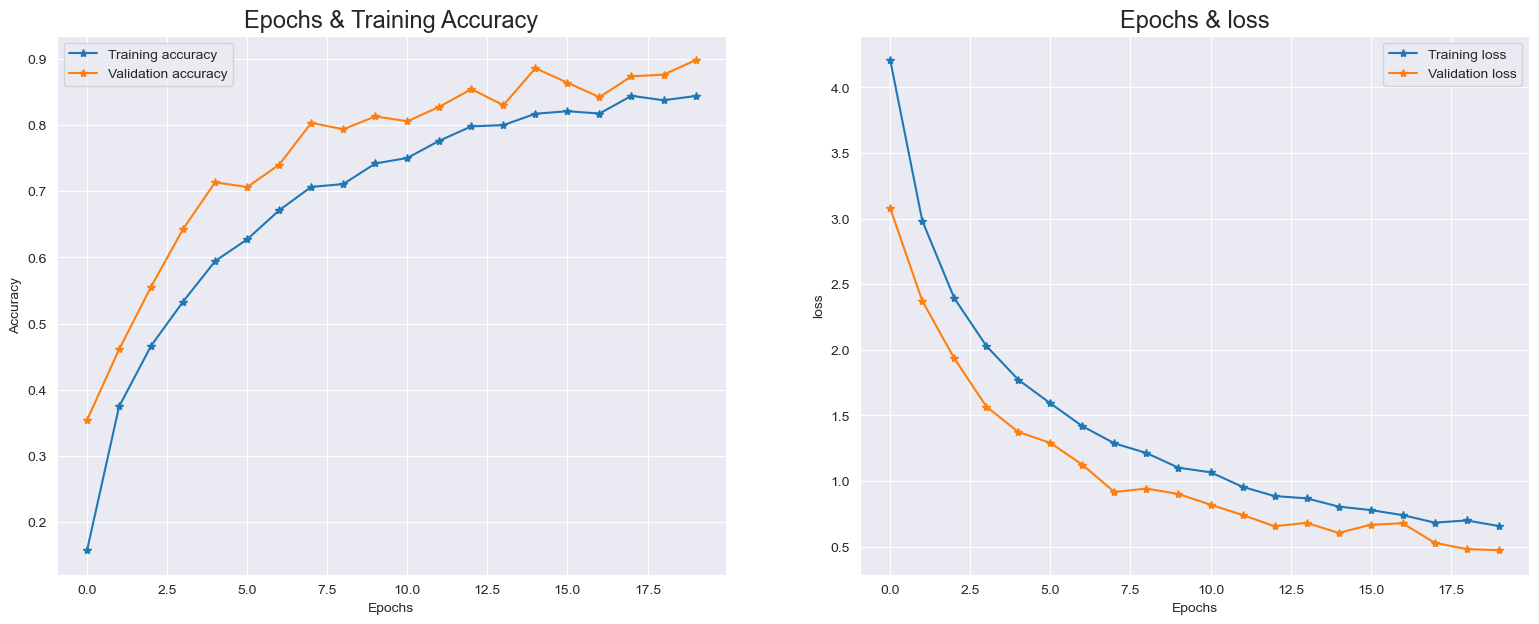

In [398]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

In [288]:
model.load_weights('/Users/bognarlili/Downloads/final_model.keras')


In [410]:
# load and evaluate best model
model.load_weights('/Users/bognarlili/Downloads/final_model.keras')
eval_data = model.evaluate(test_set)
print("Validation Loss :",eval_data[0])
print("Validation Accuracy :",eval_data[1])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.0078 - loss: 6.2170
Validation Loss : 6.29205322265625
Validation Accuracy : 0.006361322943121195


The model performs well on the training set (high training accuracy and low training loss), but performs poorly on the test data (lower validation accuracy). This may suggest that the model over-fitted to the training data, but does not generalise well to the new data.

In [411]:
def predict_pipeline(image_path):
    # Define the input image size
    input_shape = (224, 224)
            
    # load image data
    img = load_img(image_path, target_size=input_shape)
            
    # convert image to array
    x = img_to_array(img)
            
    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)
    
    # get the predicted class name
    predicted_class = labels[index]

    # Return prediced_class
    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 640x480 with 0 Axes>

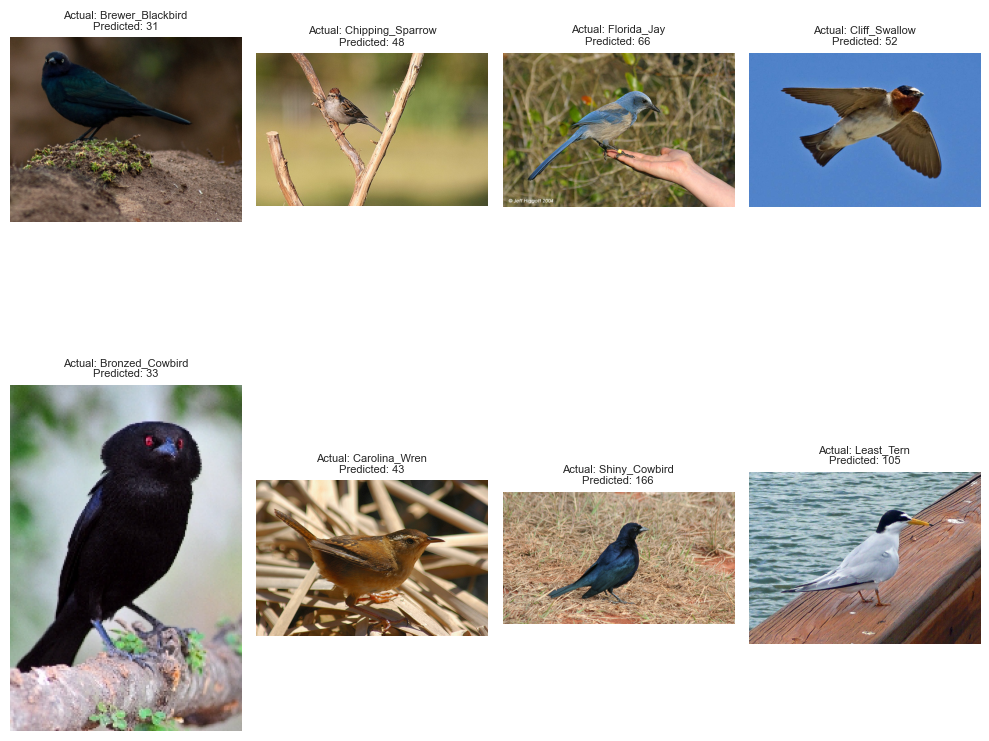

In [415]:
n_rows = 2
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

# set size of each image
fig.set_size_inches(10, 10)

species = []
img_path = {}

# choosing a image at random
for i in range(n_rows*n_cols):
    species.append(random.choice(os.listdir(valid)))

for bird in species:
    img_choice = random.choice(os.listdir(os.path.join(train,bird)))
    full_path = os.path.join(train,bird,img_choice)
    img_path[bird] = full_path

# reading and printing the image
i = 0
for key in img_path.keys():
    sp = plt.subplot(n_rows, n_cols, i + 1)
    img = mimg.imread(img_path[key])
    predicted = predict_pipeline(img_path[key])
    sp.set_title('Actual: '+str(key)+'\n'+'Predicted: '+str(predicted), fontsize=8)
    sp.axis('off')
    plt.imshow(img)
    i += 1

plt.tight_layout()

In [423]:
model = tf.keras.models.load_model('/Users/bognarlili/Downloads/final_model.keras')


In [424]:

#image directory and output CSV file
image_dir = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test_images"  # Replace with the path to your image folder
output_csv = "predictions.csv"

# Function to preprocess and predict the class of an image
def predict_pipeline(image_path):
    # Define the input image size
    input_shape = (224, 224)
    
    # Load the image
    img = load_img(image_path, target_size=input_shape)
    
    # Convert the image to a NumPy array
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    
    # Make predictions
    preds = model.predict(img_array)
    index = np.argmax(preds)  # Get the index of the predicted class
    
    # Map the index to the class name
    class_names = list(train_set.class_indices.keys())  # Replace with your class names
    predicted_class = class_names[index]
    
    return predicted_class

# Predict all images in the folder
predictions = []
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    if os.path.isfile(image_path):  # Check if it's a file
        try:
            predicted_label = predict_pipeline(image_path)
            predictions.append({"id": image_file, "label": predicted_label})
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Save predictions to a CSV file
df = pd.DataFrame(predictions)
df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 